# Example of the solution the regression problem
# Laptop price prediction
[source of the data + code of example](https://www.kaggle.com/datasets/anubhavgoyal10/laptop-prices-dataset/data)

## 0. Import the dependencies

In [1]:
import os

import numpy as np # linear algebra
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

from sklearn.model_selection import GridSearchCV

## 1. Load the data

In [3]:
df = pd.read_csv("./src/laptop_price.csv")
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


## 2. Preprocess the data

In [4]:
df.columns

Index(['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
       'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
       'weight', 'warranty', 'Touchscreen', 'msoffice', 'Price', 'rating',
       'Number of Ratings', 'Number of Reviews'],
      dtype='object')

In [5]:
# select few feature to predict the price of laptop
selected_columns = ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
                    'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
                    'weight', 'warranty', 'Touchscreen', 'Price']
df_train = df[selected_columns]

In [6]:
# check Null values in data column
print(df_train.isnull().sum())

brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
os                 0
os_bit             0
graphic_card_gb    0
weight             0
warranty           0
Touchscreen        0
Price              0
dtype: int64


In [7]:
# checking for duplicated rows
df_train.duplicated().sum()

np.int64(41)

In [8]:
# check overview of columns, their data types, and non-null counts.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    object
 4   ram_gb           823 non-null    object
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    object
 7   hdd              823 non-null    object
 8   os               823 non-null    object
 9   os_bit           823 non-null    object
 10  graphic_card_gb  823 non-null    object
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int64(1), object(14)
memory usage: 96.6+ KB


In [10]:
# make to different variables for categorical and numerical feature identification
cat_val = df_train.select_dtypes(include=['object']).columns
num_val = df_train.select_dtypes(include=['int', "float"]).columns

print(cat_val,'\n',num_val)

Index(['brand', 'processor_brand', 'processor_name', 'processor_gnrtn',
       'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb',
       'weight', 'warranty', 'Touchscreen'],
      dtype='object') 
 Index(['Price'], dtype='object')


In [11]:
# check all unique values in features
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'brand': ['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
Unique values in column 'processor_brand': ['Intel' 'AMD' 'M1']
Unique values in column 'processor_name': ['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
Unique values in column 'processor_gnrtn': ['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
Unique values in column 'ram_gb': ['4 GB' '8 GB' '16 GB' '32 GB']
Unique values in column 'ram_type': ['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
Unique values in column 'ssd': ['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
Unique values in column 'hdd': ['1024 GB' '0 GB' '512 GB' '2048 GB']
Unique values in column 'os': ['Windows' 'DOS' 'Mac']
Unique values in column 'os_bit': ['64-bit' '32-bit']
Unique values in column 'graphic_card_gb': ['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
Unique values in column 'weight': ['Casual' 'ThinNlight' 'Gaming']
Uniq

In [12]:
# Removed units ('GB', 'years', 'bit', etc.) from certain columns using string manipulation (str.replace) 
# and transformed them into appropriate numeric types (astype or pd.to_numeric)
df_train['ram_gb'] = df_train['ram_gb'].str.replace('GB','')
df_train['ssd'] = df_train['ssd'].str.replace('GB','')
df_train['hdd'] = df_train['hdd'].str.replace('GB','')
df_train['graphic_card_gb'] = df_train['graphic_card_gb'].str.replace('GB','')
df_train['os_bit'] = df_train['os_bit'].str.replace('-bit','')
df_train['warranty'] = df_train['warranty'].str.replace(r'\byears?\b', '', regex=True)
df_train['processor_gnrtn'] = df_train['processor_gnrtn'].str.replace('th','')


df_train['ram_gb'] = df_train['ram_gb'].astype('int32')
df_train['ssd'] = df_train['ssd'].astype('int32')
df_train['hdd'] = df_train['hdd'].astype('int32')
df_train['graphic_card_gb'] = df_train['graphic_card_gb'].astype('int32')
df_train['os_bit'] = df_train['os_bit'].astype('int32')

df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,Not Available,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [13]:
# Convert to numeric, 'Not Available' becomes NaN
df_train['processor_gnrtn'] = pd.to_numeric(df_train['processor_gnrtn'], errors='coerce')  # Convert to numeric, 'Not Available' becomes NaN
median_value = df_train['processor_gnrtn'].median()

In [14]:
df_train['processor_gnrtn'].fillna(median_value, inplace=True)
df_train['processor_gnrtn'] = df_train['processor_gnrtn'].astype(int)

In [15]:
df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


In [17]:
df_train.isnull().sum()

brand              0
processor_brand    0
processor_name     0
processor_gnrtn    0
ram_gb             0
ram_type           0
ssd                0
hdd                0
os                 0
os_bit             0
graphic_card_gb    0
weight             0
warranty           0
Touchscreen        0
Price              0
dtype: int64

## 3. Do data visualization

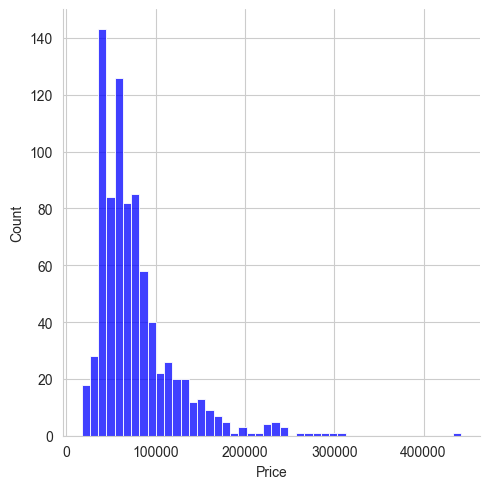

In [18]:
sns.displot(df['Price'],color='blue')

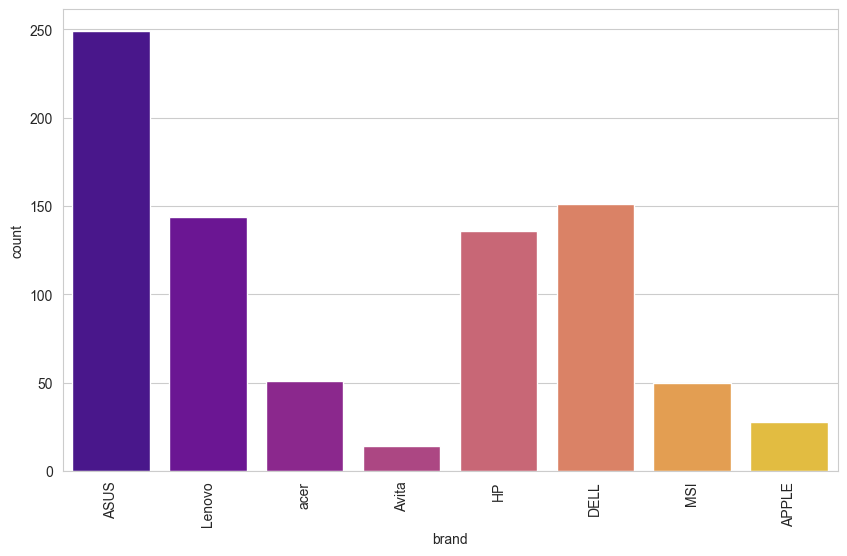

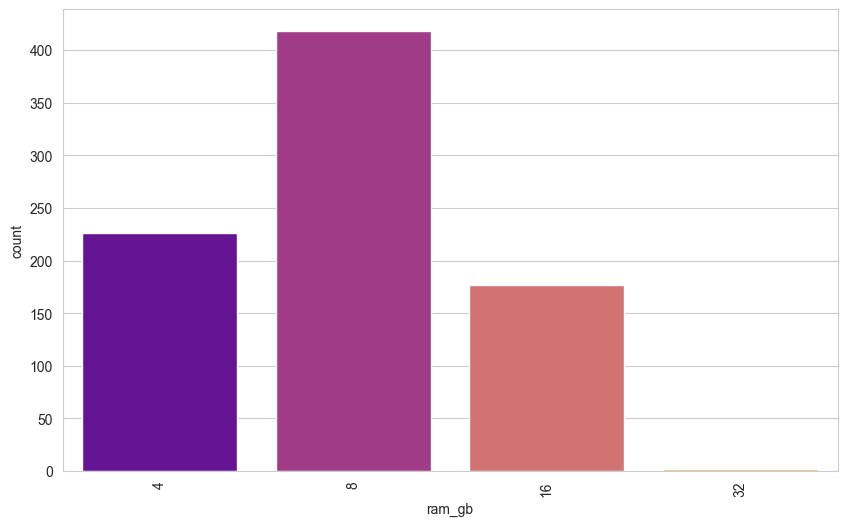

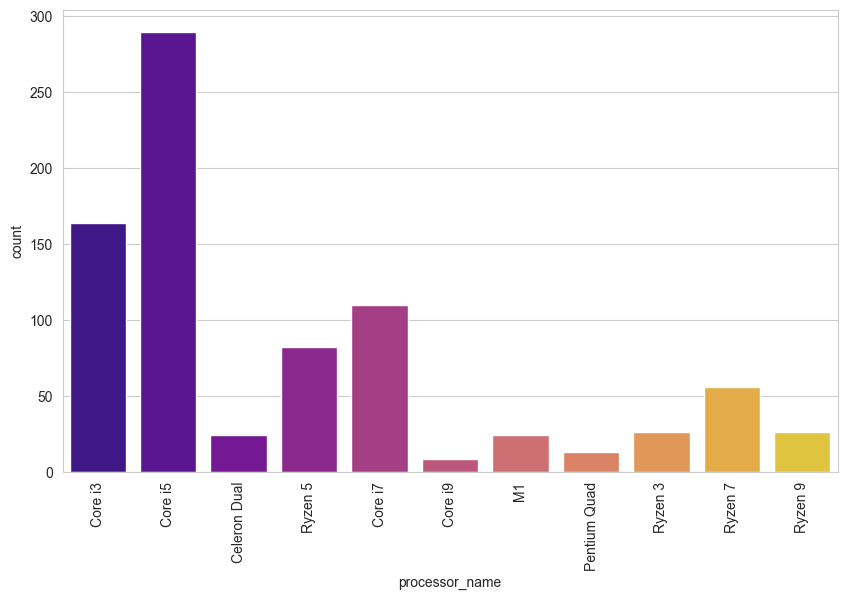

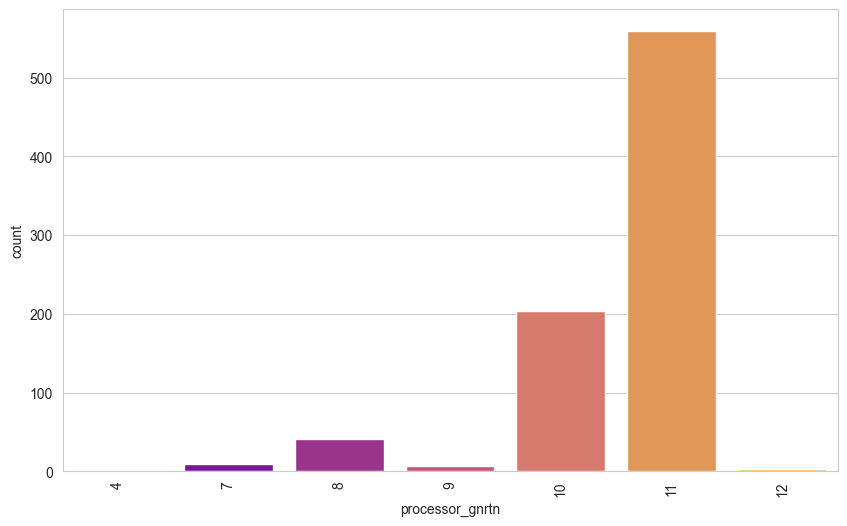

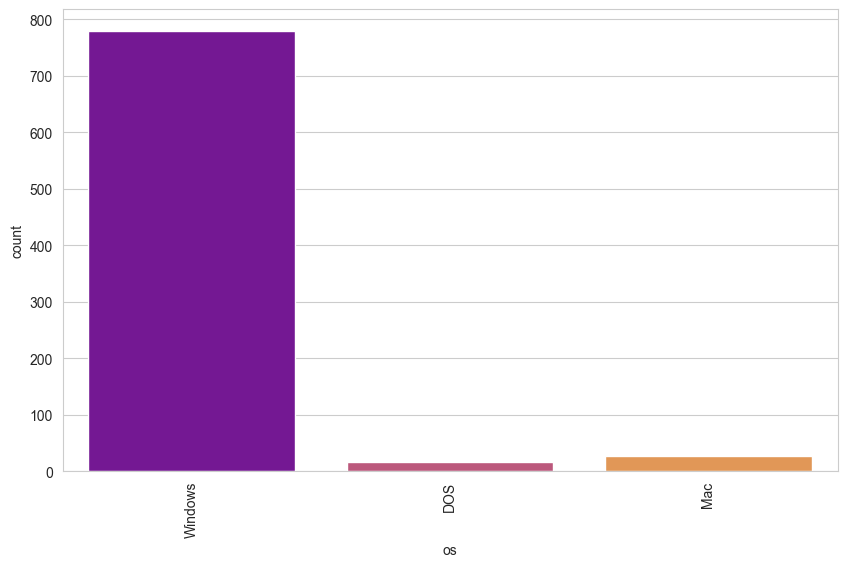

In [19]:
def dataplot(col):
    plt.figure(figsize= (10,6))
    sns.countplot(data = df_train, x=col, palette = 'plasma')
    plt.xticks(rotation = 'vertical')
    plt.show()
    
features = ['brand', 'ram_gb', 'processor_name', 'processor_gnrtn', 'os']

for col in features:
    dataplot(col)

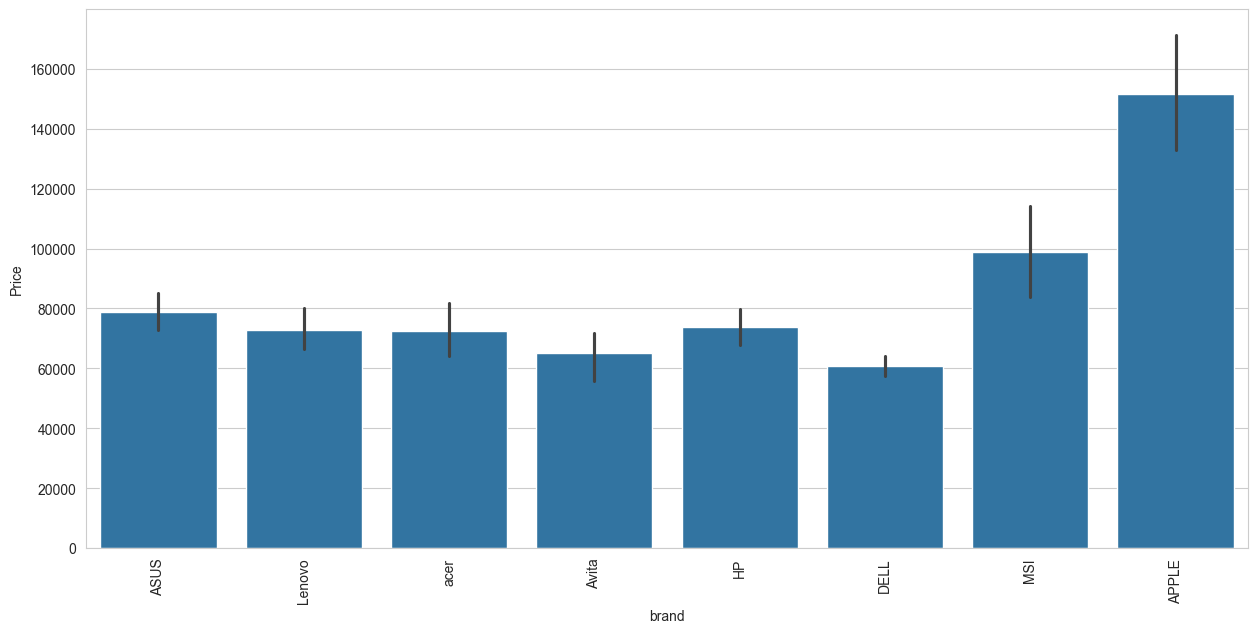

In [20]:
plt.figure(figsize=(15,7))
sns.barplot(x = df_train['brand'], y=df_train['Price'])
plt.xticks(rotation = 'vertical')
plt.show()

### Visualize the Touchscreen feature

<Axes: xlabel='Touchscreen', ylabel='count'>

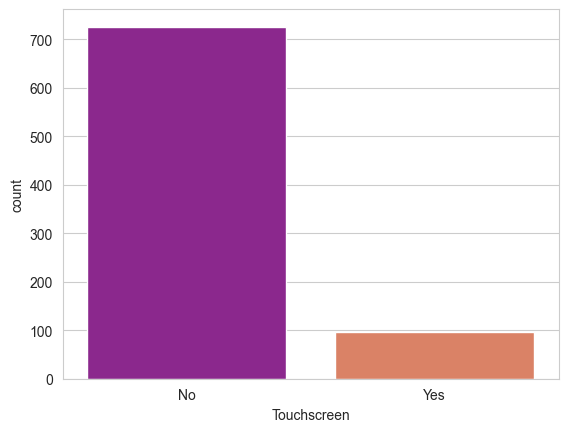

In [21]:
sns.countplot(df_train, x =df_train['Touchscreen'],palette='plasma')

<Axes: xlabel='Touchscreen', ylabel='Price'>

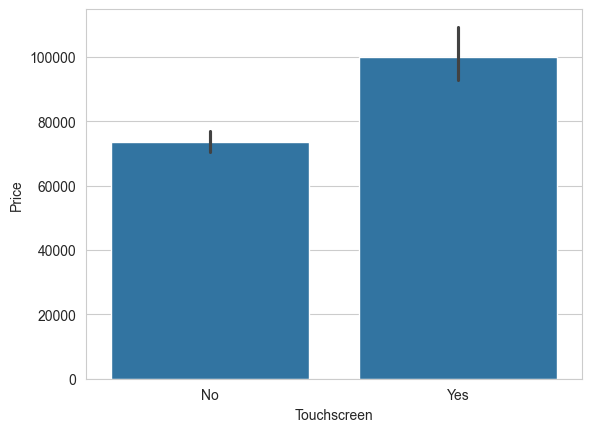

In [22]:
sns.barplot(x = df_train['Touchscreen'], y= df_train['Price'])

### Visualize the Warranty feature

<Axes: xlabel='warranty', ylabel='count'>

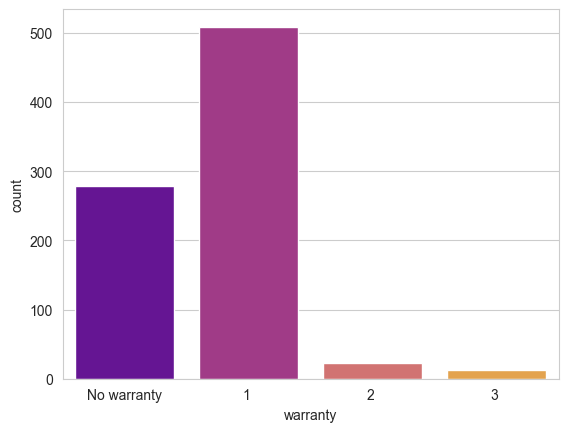

In [23]:
sns.countplot(df_train, x =df_train['warranty'],palette='plasma')

<Axes: xlabel='warranty', ylabel='Price'>

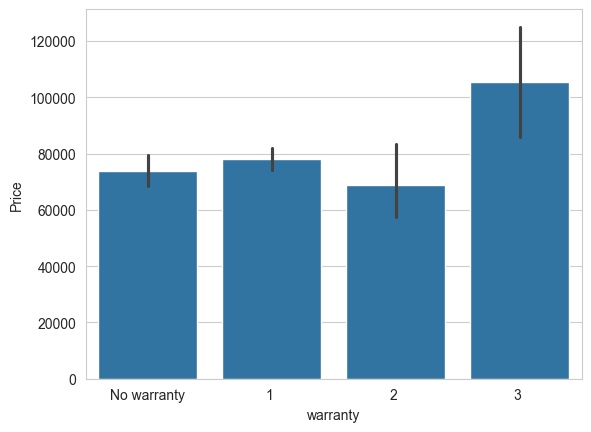

In [24]:
sns.barplot(x = df_train['warranty'], y= df_train['Price'])

### Visualize the Weight feature

<Axes: xlabel='weight', ylabel='count'>

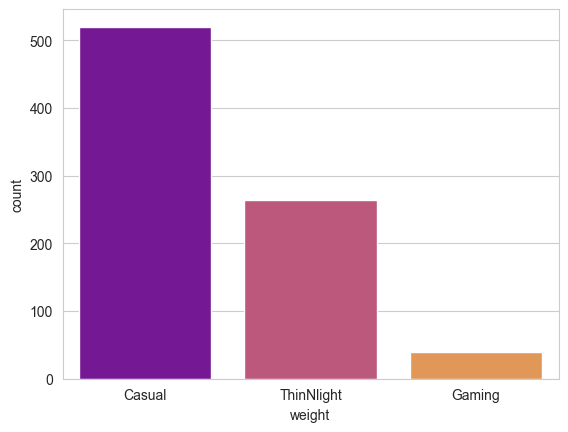

In [25]:
sns.countplot(df_train, x =df_train['weight'],palette='plasma')

<Axes: xlabel='weight', ylabel='Price'>

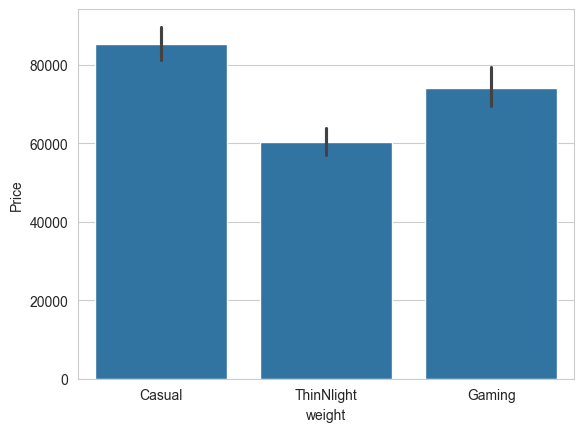

In [26]:
sns.barplot(x = df_train['weight'], y= df_train['Price'])

### Visualize the RAM

<Axes: xlabel='ram_gb', ylabel='count'>

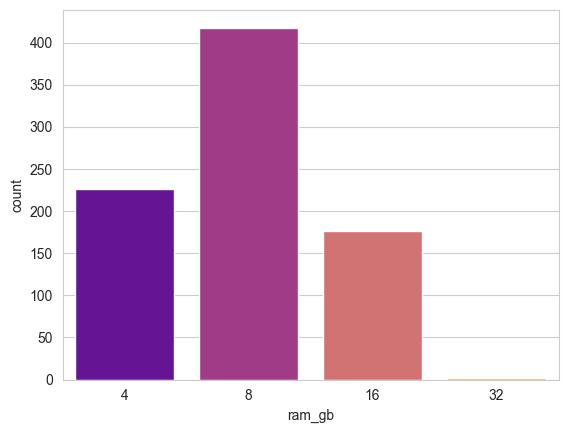

In [27]:
sns.countplot(df_train, x =df_train['ram_gb'],palette='plasma')

<Axes: xlabel='ram_gb', ylabel='Price'>

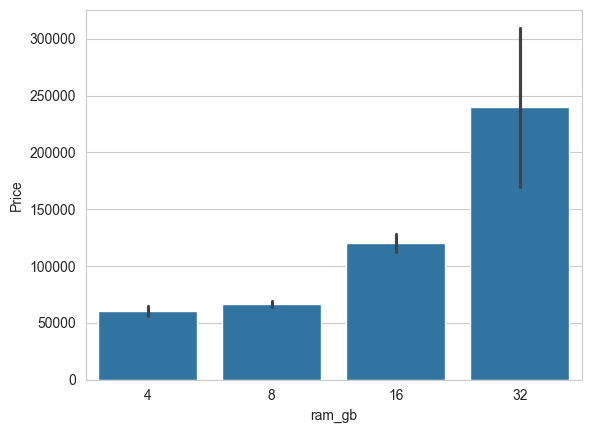

In [28]:
sns.barplot(x = df_train['ram_gb'], y= df_train['Price'])

In [29]:
df_train.sample(10)

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
792,HP,AMD,Ryzen 7,11,16,DDR4,256,1024,Windows,64,4,Gaming,1,No,75990
469,DELL,Intel,Core i5,11,8,DDR4,256,1024,Windows,64,2,Casual,No warranty,No,67490
660,DELL,AMD,Ryzen 3,11,8,DDR4,0,1024,Windows,64,0,ThinNlight,No warranty,No,39990
662,DELL,AMD,Ryzen 5,11,8,DDR4,256,0,Windows,64,0,Casual,1,No,41990
191,HP,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,27990
342,Lenovo,Intel,Core i5,11,8,DDR4,512,0,Windows,64,0,ThinNlight,1,No,65990
513,HP,Intel,Core i7,10,16,DDR4,512,0,Windows,64,0,Casual,1,Yes,162990
288,DELL,Intel,Core i5,11,8,DDR4,512,0,Windows,64,0,ThinNlight,1,No,69490
180,ASUS,Intel,Core i3,10,4,DDR4,256,1024,Windows,64,0,Casual,No warranty,No,40990
303,MSI,Intel,Core i5,11,8,DDR4,512,0,Windows,64,0,Casual,1,No,55490


### Visualize the Operating_system

<Axes: xlabel='os', ylabel='count'>

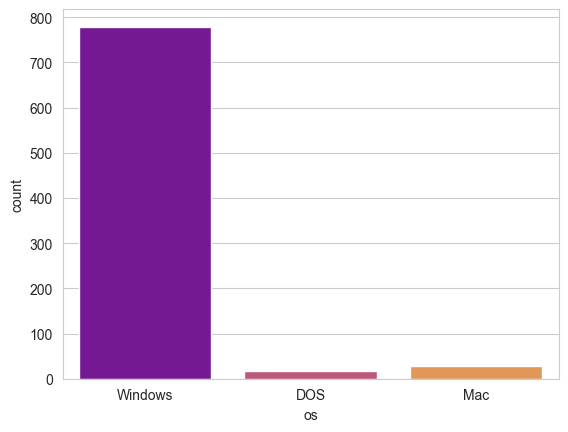

In [30]:
sns.countplot(df_train, x =df_train['os'],palette='plasma')

<Axes: xlabel='os', ylabel='Price'>

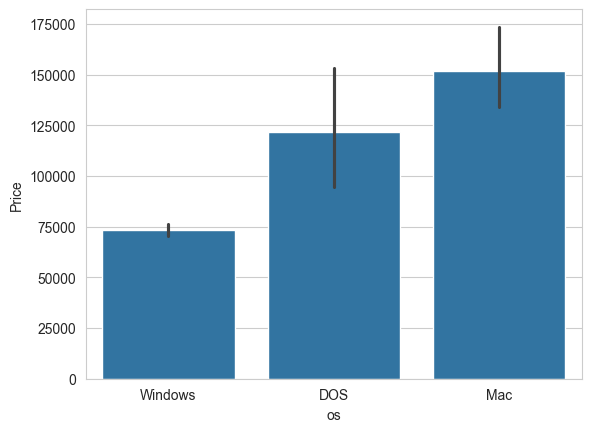

In [31]:
sns.barplot(x = df_train['os'], y= df_train['Price'])

### Visualize the Price

<Axes: xlabel='Price', ylabel='Density'>

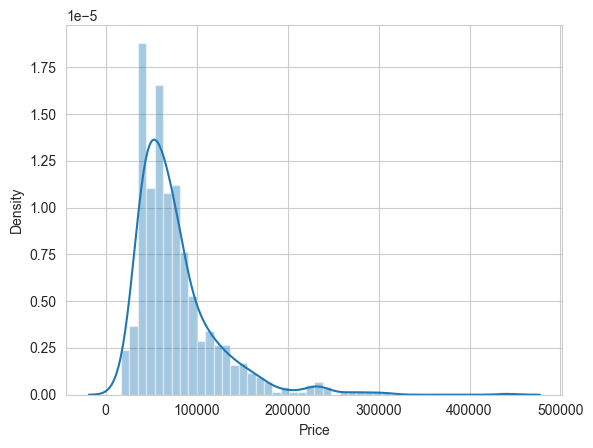

In [32]:
sns.distplot(df_train['Price'])

<Axes: xlabel='Price', ylabel='Density'>

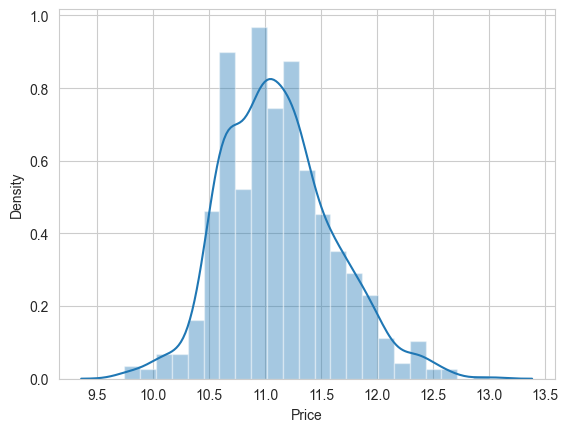

In [33]:
sns.distplot(np.log(df_train['Price']))

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


<Axes: >

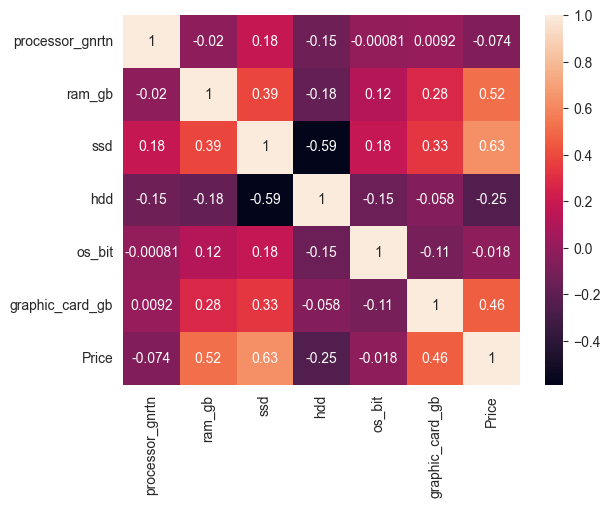

In [35]:
numeric_df = df_train.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True)

## 4. Final data preps

In [36]:
x = df_train.drop(['Price'], axis=1)
y = np.log(df_train['Price'])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=8418)
X_train.shape, X_test.shape

((699, 14), (124, 14))

In [38]:
mapper = {i:value for i,value in enumerate(X_train.columns)}
mapper

{0: 'brand',
 1: 'processor_brand',
 2: 'processor_name',
 3: 'processor_gnrtn',
 4: 'ram_gb',
 5: 'ram_type',
 6: 'ssd',
 7: 'hdd',
 8: 'os',
 9: 'os_bit',
 10: 'graphic_card_gb',
 11: 'weight',
 12: 'warranty',
 13: 'Touchscreen'}

In [39]:
df_train.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            823 non-null    object
 1   processor_brand  823 non-null    object
 2   processor_name   823 non-null    object
 3   processor_gnrtn  823 non-null    int64 
 4   ram_gb           823 non-null    int32 
 5   ram_type         823 non-null    object
 6   ssd              823 non-null    int32 
 7   hdd              823 non-null    int32 
 8   os               823 non-null    object
 9   os_bit           823 non-null    int32 
 10  graphic_card_gb  823 non-null    int32 
 11  weight           823 non-null    object
 12  warranty         823 non-null    object
 13  Touchscreen      823 non-null    object
 14  Price            823 non-null    int64 
dtypes: int32(5), int64(2), object(8)
memory usage: 80.5+ KB


## 5.1 Test Linear Regression method

In [41]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

lr = LinearRegression()

pipe = Pipeline([
    ('encoding', encoding),
    ('lr', lr)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.8663048188898103
Train MAE 0.12809545829978325
Train MAE on the orig price: 1.1366615012927748 

Test R2 score 0.8509808026096805
Test MAE 0.14356278102642966
Test MAE on the orig price: 1.154379281648378


## 5.2 Test Lasso Regression

In [42]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

lasso = Lasso(alpha=0.001)

pipe = Pipeline([
    ('encoding', encoding),
    ('lasso', lasso)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.8539145775181127
Train MAE 0.1343102892681184
Train MAE on the orig price: 1.143747657214124 

Test R2 score 0.8227381157196224
Test MAE 0.15846844070149596
Test MAE on the orig price: 1.1717149451399707


## 5.3. Decision Tree

In [44]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

dtr = DecisionTreeRegressor(max_depth=8)

pipe = Pipeline([
    ('encoding', encoding),
    ('dtr', dtr)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.8929483768816412
Train MAE 0.10792686622351398
Train MAE on the orig price: 1.1139662738468588 

Test R2 score 0.7710074973261902
Test MAE 0.17878113081620334
Test MAE on the orig price: 1.195759000728635


## 5.4. Random Forest

In [46]:
encoding = ColumnTransformer(transformers = [
    ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'), [0, 1, 2, 5, 8, 11, 12, 13])
], remainder='passthrough')

random = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.75,
                              max_depth=15)

pipe = Pipeline([
    ('encoding', encoding),
    ('random', random)
])

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.9350059476104549
Train MAE 0.08463718344688273
Train MAE on the orig price: 1.0883221337733728 

Test R2 score 0.8583367845839139
Test MAE 0.14201903920592035
Test MAE on the orig price: 1.1525985928900564


## 5.4.1 You can also tune hyperparameters of Random Forest

In [47]:
indexlist = [0, 1, 2, 5, 8, 11, 12, 13]
transformlist = []
for key,value in mapper.items():
    if key in indexlist:
        transformlist.append(value)
        
transformlist

['brand',
 'processor_brand',
 'processor_name',
 'ram_type',
 'os',
 'weight',
 'warranty',
 'Touchscreen']

In [48]:
x = pd.get_dummies(x,columns=transformlist,drop_first=True)
x.head()

,processor_gnrtn,ram_gb,ssd,hdd,os_bit,graphic_card_gb,brand_ASUS,brand_Avita,brand_DELL,brand_HP,...,ram_type_LPDDR4,ram_type_LPDDR4X,os_Mac,os_Windows,weight_Gaming,weight_ThinNlight,warranty_2,warranty_3,warranty_No warranty,Touchscreen_Yes
0,10,4,0,1024,64,0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,10,4,0,1024,64,0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,10,4,0,1024,64,0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,10,8,512,0,32,2,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,11,4,0,512,64,0,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [49]:
X_train, X_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.15,random_state=4818)

X_train.shape,X_test.shape

((699, 38), (124, 38))

In [50]:
rfr = RandomForestRegressor()

In [51]:
param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

In [52]:
grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2')

In [53]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]},
             scoring='r2')

In [54]:
print('Best hyper parameter :' , grid_search.best_params_)
print('Best model :' , grid_search.best_estimator_)

Best hyper parameter : {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 20}
Best model : RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=20)


In [56]:
rfr =  RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=2,
                      n_estimators=20)

In [57]:
rf_grid = rfr.fit(X_train,y_train)

In [59]:
y_train_pred = rf_grid.predict(X_train)
y_pred = rf_grid.predict(X_test)

print('Train R2 score', metrics.r2_score(y_train,y_train_pred))
print('Train MAE', metrics.mean_absolute_error(y_train,y_train_pred))
print("Train MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_train,y_train_pred)), "\n")

print('Test R2 score', metrics.r2_score(y_test,y_pred))
print('Test MAE', metrics.mean_absolute_error(y_test,y_pred))
print("Test MAE on the orig price:", np.exp(metrics.mean_absolute_error(y_test,y_pred)))

Train R2 score 0.9826630769813087
Train MAE 0.026564926196946177
Train MAE on the orig price: 1.026920919167128 

Test R2 score 0.851577138178187
Test MAE 0.12952713398311305
Test MAE on the orig price: 1.1382899973853207


In [60]:
predicted = []
testtrain = np.array(x)
for i in range(len(testtrain)):
    predicted.append(rfr.predict([testtrain[i]]))
    
predicted

[array([10.49918279]),
 array([10.58395051]),
 array([10.58395051]),
 array([11.15610765]),
 array([10.09628365]),
 array([10.09628365]),
 array([9.99834308]),
 array([10.98188013]),
 array([10.81975828]),
 array([11.00193316]),
 array([11.44785347]),
 array([11.00193316]),
 array([9.76938457]),
 array([10.09628365]),
 array([10.4909964]),
 array([10.91918652]),
 array([11.08812462]),
 array([10.37345993]),
 array([10.38868763]),
 array([10.37345993]),
 array([10.30527926]),
 array([10.28223747]),
 array([10.40289827]),
 array([10.74073508]),
 array([10.44665451]),
 array([10.54507825]),
 array([10.4909964]),
 array([10.4335274]),
 array([10.5963847]),
 array([10.58380275]),
 array([10.91918652]),
 array([10.57106048]),
 array([10.54507825]),
 array([10.64323869]),
 array([10.60421065]),
 array([10.54507825]),
 array([10.69572041]),
 array([10.64323869]),
 array([10.60421065]),
 array([10.6511054]),
 array([10.59060387]),
 array([10.89655412]),
 array([10.51840288]),
 array([10.5966097

In [61]:
ans = [np.exp(predicted[i][0]) for i in range(len(predicted))]

In [62]:
rounded_prices = [round(pred) for pred in ans]

In [63]:
df_train['Predicted Price'] = np.array(rounded_prices)
df_train

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,Price,Predicted Price
0,ASUS,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,34649,36286
1,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,38999,39496
2,Lenovo,Intel,Core i3,10,4,DDR4,0,1024,Windows,64,0,Casual,No warranty,No,39999,39496
3,ASUS,Intel,Core i5,10,8,DDR4,512,0,Windows,32,2,Casual,No warranty,No,69990,69990
4,ASUS,Intel,Celeron Dual,11,4,DDR4,0,512,Windows,64,0,Casual,No warranty,No,26990,24253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,0,Casual,1,No,135990,127440
819,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,0,Casual,1,No,144990,127440
820,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,4,Casual,1,No,149990,151767
821,ASUS,AMD,Ryzen 9,11,4,DDR4,1024,0,Windows,64,4,Casual,1,No,142990,151767


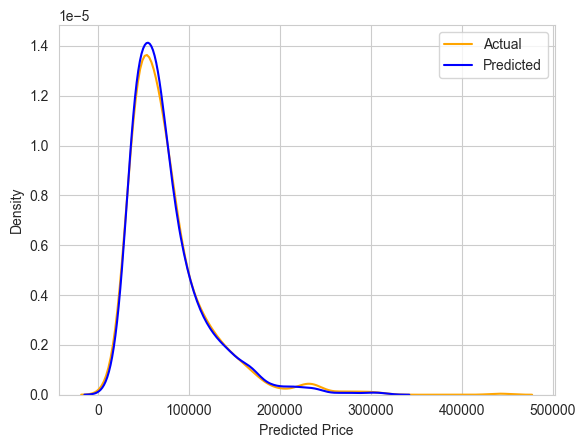

In [64]:
sns.distplot(df_train['Price'],hist=False,color='orange',label='Actual')
sns.distplot(df_train['Predicted Price'],hist=False,color='blue',label='Predicted')
plt.legend()
plt.show()

# The lab work task
Solve the regression problem for the one of the presented datasets using the same steps into your work.
To get you variant: (your_num % 9), where your_num is your number in the group list.

In addition to presented in the example methods consider other ML methods like Support Vector Machine, Gradient Boosting Regression, Bayesian Ridge Regression.

Present your work in the Jupyter Notebook variant

P.s. in provided data sources you can find examples of solving this problem, but be ready to explain the code and results.

# Data to choose
1. [Gold Price Prediction](https://www.kaggle.com/datasets/franciscogcc/financial-data)
2. [Possum Regression](https://www.kaggle.com/datasets/abrambeyer/openintro-possum/data)
3. [Student Performance](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)
4. [Boston House Prices](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data/data)
5. [Car Price](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction)
6. [Medical Cost](https://www.kaggle.com/datasets/mirichoi0218/insurance)
7. [Crab Age Prediction](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)
8. [Calculate Concrete Strength](https://www.kaggle.com/datasets/prathamtripathi/regression-with-neural-networking)
9. [Advertising dataset](https://www.kaggle.com/datasets/tawfikelmetwally/advertising-dataset)